In [626]:
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import TimeSeriesSplit
from scipy import stats
from collections import Counter
from sklearn.metrics import accuracy_score

In [627]:
weather = pd.read_csv("../Tan - Random Forest/hanoiweather.csv")

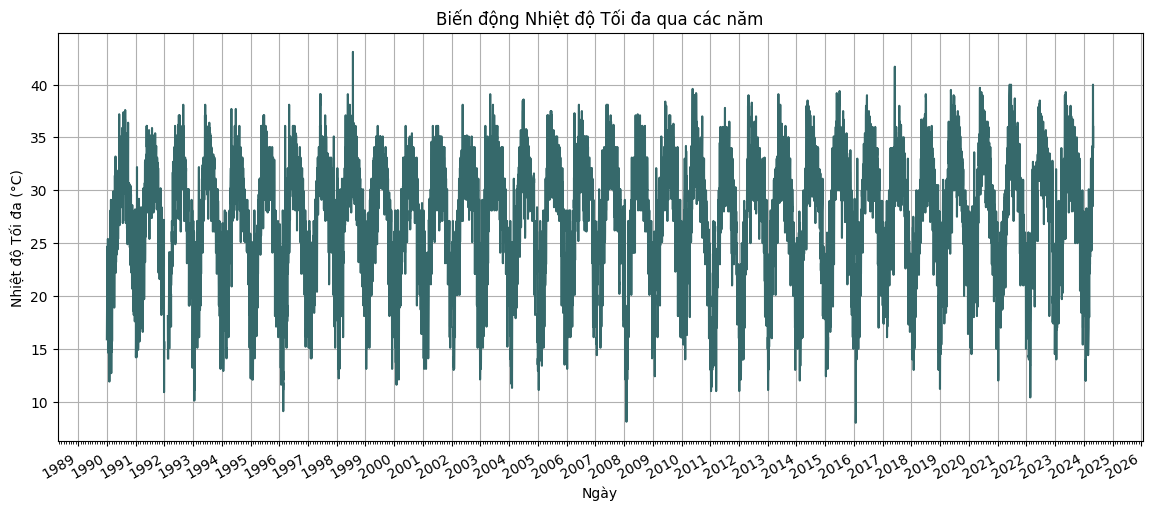

In [628]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

df =weather
# Giả sử 'df' là DataFrame của bạn chứa cột 'datetime' và 'tempmax'
# Đảm bảo rằng cột 'datetime' đã được chuyển đổi thành kiểu dữ liệu datetime
df['datetime'] = pd.to_datetime(df['datetime'])

# Tạo biểu đồ
plt.figure(figsize=(14, 6))  # Tùy chỉnh kích thước biểu đồ
plt.plot(df['datetime'], df['tempmax'], marker='', linestyle='-', color='#36696b')

# Định dạng trục x
plt.gca().xaxis.set_major_locator(mdates.YearLocator())  # Đặt vị trí các dấu lớn theo từng năm
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Định dạng hiển thị là năm
plt.gca().xaxis.set_minor_locator(mdates.MonthLocator())  # Đặt vị trí các dấu nhỏ theo từng tháng

plt.gcf().autofmt_xdate()  # Tự động điều chỉnh định dạng ngày dọc theo trục x để không bị chồng chéo
plt.title('Biến động Nhiệt độ Tối đa qua các năm')  # Tiêu đề biểu đồ
plt.xlabel('Ngày')  # Nhãn cho trục x
plt.ylabel('Nhiệt độ Tối đa (°C)')  # Nhãn cho trục y
plt.grid(True)  # Hiển thị lưới
plt.show()


In [629]:
max_temperature = df['tempmax'].max()
min_temperature = df['tempmin'].min()

print("Nhiệt độ tối đa trong bộ dữ liệu là:", max_temperature, "°C")
print("Nhiệt độ tối thiểu trong bộ dữ liệu là:", min_temperature, "°C")

Nhiệt độ tối đa trong bộ dữ liệu là: 43.1 °C
Nhiệt độ tối thiểu trong bộ dữ liệu là: 3.8 °C


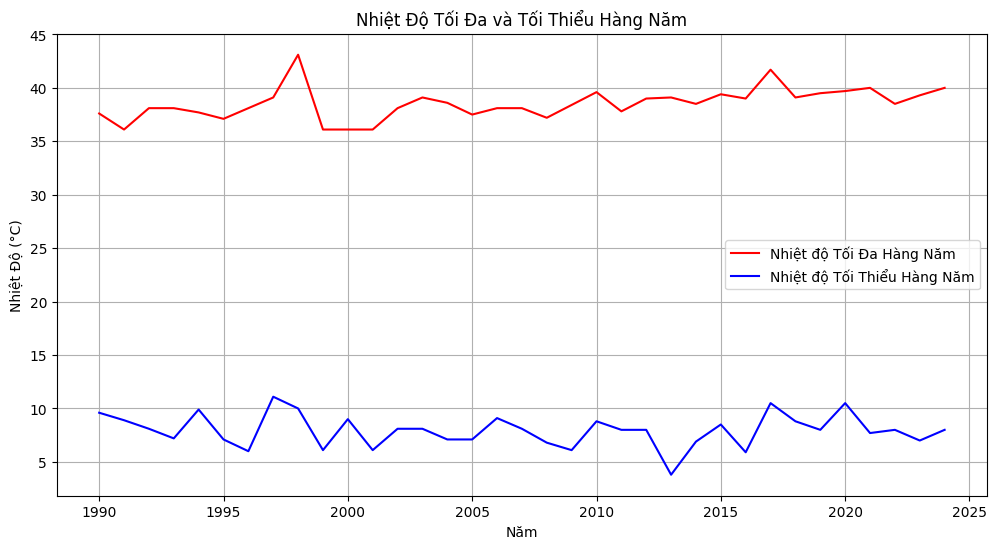

In [630]:
import matplotlib.pyplot as plt

# Tạo biểu đồ
plt.figure(figsize=(12, 6))

# Vẽ đường cho nhiệt độ tối đa hàng năm
plt.plot(annual_max_temps, label='Nhiệt độ Tối Đa Hàng Năm', color='red')

# Vẽ đường cho nhiệt độ tối thiểu hàng năm
plt.plot(annual_min_temps, label='Nhiệt độ Tối Thiểu Hàng Năm', color='blue')

# Thêm tiêu đề và nhãn
plt.title('Nhiệt Độ Tối Đa và Tối Thiểu Hàng Năm')
plt.xlabel('Năm')
plt.ylabel('Nhiệt Độ (°C)')

# Thêm chú thích
plt.legend()

# Hiển thị lưới
plt.grid(True)

# Hiển thị biểu đồ
plt.show()


In [631]:
from datetime import datetime

def time_to_minutes(time_str):
    # Định nghĩa các định dạng thời gian khác nhau
    formats = ["%Y-%m-%dT%H:%M:%S", "%Y-%m-%d %H:%M:%S"]
    
    for fmt in formats:
        try:
            # Cố gắng phân tích chuỗi thời gian với từng định dạng
            time_obj = datetime.strptime(time_str, fmt)
            return time_obj.hour * 60 + time_obj.minute
        except ValueError:
            # Nếu định dạng không khớp, thử định dạng tiếp theo
            continue
    
    # Nếu không có định dạng nào khớp, in lỗi
    raise ValueError(f"Thời gian '{time_str}' không khớp với bất kỳ định dạng nào đã biết")

# Biến đổi thời gian của sunrise và sunset
weather['sunrise_minutes'] = weather['sunrise'].apply(time_to_minutes)
weather['sunset_minutes'] = weather['sunset'].apply(time_to_minutes)

In [632]:
weather

,name,datetime,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,...,severerisk,sunrise,sunset,moonphase,conditions,description,icon,stations,sunrise_minutes,sunset_minutes
0,Hà Nội,1990-01-01,15.9,13.4,14.6,15.9,13.4,14.6,14.0,96.3,...,NaN,1990-01-01T06:33:41,1990-01-01T17:26:18,0.14,Overcast,Cloudy skies throughout the day.,cloudy,48820099999,393,1046
1,Hà Nội,1990-01-02,17.4,14.6,16.1,17.4,14.6,16.1,13.7,85.9,...,NaN,1990-01-02T06:34:00,1990-01-02T17:26:56,0.18,Overcast,Cloudy skies throughout the day.,cloudy,48820099999,394,1046
2,Hà Nội,1990-01-03,18.2,16.1,16.8,18.2,16.1,16.8,13.8,82.5,...,NaN,1990-01-03T06:34:18,1990-01-03T17:27:34,0.22,Overcast,Cloudy skies throughout the day.,cloudy,48820099999,394,1047
3,Hà Nội,1990-01-04,19.6,15.2,16.4,19.6,15.2,16.4,14.3,88.2,...,NaN,1990-01-04T06:34:35,1990-01-04T17:28:12,0.25,Overcast,Cloudy skies throughout the day.,cloudy,48820099999,394,1048
4,Hà Nội,1990-01-05,18.1,15.4,16.9,18.1,15.4,16.9,15.8,93.8,...,NaN,1990-01-05T06:34:51,1990-01-05T17:28:51,0.29,Overcast,Cloudy skies throughout the day.,cloudy,48820099999,394,1048
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12534,Hà Nội,2024-04-26,36.0,27.0,30.9,47.9,31.0,39.6,26.9,80.8,...,60.0,2024-04-26T05:29:23,2024-04-26T18:19:42,0.58,Partially cloudy,Clearing in the afternoon.,partly-cloudy-day,VVNB,329,1099
12535,Hà Nội,2024-04-27,40.0,27.0,32.2,44.7,31.2,38.6,24.7,69.9,...,30.0,2024-04-27T05:28:42,2024-04-27T18:20:04,0.61,Clear,Clear conditions throughout the day.,clear-day,"48820099999,48823099999,48825099999,4883109999...",328,1100
12536,Hà Nội,2024-04-28,35.0,27.0,30.4,50.8,30.5,39.4,27.0,82.7,...,60.0,2024-04-28T05:28:02,2024-04-28T18:20:27,0.65,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day,"48820099999,48823099999,48825099999,4883109999...",328,1100
12537,Hà Nội,2024-04-29,34.0,28.0,30.2,49.3,34.4,39.4,27.4,85.3,...,75.0,2024-04-29T05:27:22,2024-04-29T18:20:49,0.68,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day,VVNB,327,1100


In [633]:
# Tạo cột mới có giá trị là nhiệt độ cao nhất của ngày hôm sau 
weather['tempmax_next'] = weather['tempmax'].shift(-1)

In [634]:
weather.head(5)

,name,datetime,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,...,sunrise,sunset,moonphase,conditions,description,icon,stations,sunrise_minutes,sunset_minutes,tempmax_next
0,Hà Nội,1990-01-01,15.9,13.4,14.6,15.9,13.4,14.6,14.0,96.3,...,1990-01-01T06:33:41,1990-01-01T17:26:18,0.14,Overcast,Cloudy skies throughout the day.,cloudy,48820099999,393,1046,17.4
1,Hà Nội,1990-01-02,17.4,14.6,16.1,17.4,14.6,16.1,13.7,85.9,...,1990-01-02T06:34:00,1990-01-02T17:26:56,0.18,Overcast,Cloudy skies throughout the day.,cloudy,48820099999,394,1046,18.2
2,Hà Nội,1990-01-03,18.2,16.1,16.8,18.2,16.1,16.8,13.8,82.5,...,1990-01-03T06:34:18,1990-01-03T17:27:34,0.22,Overcast,Cloudy skies throughout the day.,cloudy,48820099999,394,1047,19.6
3,Hà Nội,1990-01-04,19.6,15.2,16.4,19.6,15.2,16.4,14.3,88.2,...,1990-01-04T06:34:35,1990-01-04T17:28:12,0.25,Overcast,Cloudy skies throughout the day.,cloudy,48820099999,394,1048,18.1
4,Hà Nội,1990-01-05,18.1,15.4,16.9,18.1,15.4,16.9,15.8,93.8,...,1990-01-05T06:34:51,1990-01-05T17:28:51,0.29,Overcast,Cloudy skies throughout the day.,cloudy,48820099999,394,1048,17.7


In [635]:
# Xử lý dữ liệu khuyết do hàng cuối sẽ là NaN => bỏ dòng cuối
weather = weather[:-1]

In [636]:

se = ((weather['tempmax_next'] - weather['tempmax']) ** 2)
print(se.mean())

6.494913786189751


In [637]:
# Mã hoá Conditions vì là dữ liệu phân loại 
conditions_encoded = pd.get_dummies(weather['conditions'], prefix='cond')
weather= pd.concat([weather, conditions_encoded], axis=1)

In [638]:
weather

,name,datetime,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,...,stations,sunrise_minutes,sunset_minutes,tempmax_next,cond_Clear,cond_Overcast,cond_Partially cloudy,cond_Rain,"cond_Rain, Overcast","cond_Rain, Partially cloudy"
0,Hà Nội,1990-01-01,15.9,13.4,14.6,15.9,13.4,14.6,14.0,96.3,...,48820099999,393,1046,17.4,False,True,False,False,False,False
1,Hà Nội,1990-01-02,17.4,14.6,16.1,17.4,14.6,16.1,13.7,85.9,...,48820099999,394,1046,18.2,False,True,False,False,False,False
2,Hà Nội,1990-01-03,18.2,16.1,16.8,18.2,16.1,16.8,13.8,82.5,...,48820099999,394,1047,19.6,False,True,False,False,False,False
3,Hà Nội,1990-01-04,19.6,15.2,16.4,19.6,15.2,16.4,14.3,88.2,...,48820099999,394,1048,18.1,False,True,False,False,False,False
4,Hà Nội,1990-01-05,18.1,15.4,16.9,18.1,15.4,16.9,15.8,93.8,...,48820099999,394,1048,17.7,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12533,Hà Nội,2024-04-25,34.0,25.0,28.9,45.6,25.0,34.5,25.9,84.7,...,"48820099999,48823099999,48825099999,4883109999...",330,1099,36.0,False,False,False,False,False,True
12534,Hà Nội,2024-04-26,36.0,27.0,30.9,47.9,31.0,39.6,26.9,80.8,...,VVNB,329,1099,40.0,False,False,True,False,False,False
12535,Hà Nội,2024-04-27,40.0,27.0,32.2,44.7,31.2,38.6,24.7,69.9,...,"48820099999,48823099999,48825099999,4883109999...",328,1100,35.0,True,False,False,False,False,False
12536,Hà Nội,2024-04-28,35.0,27.0,30.4,50.8,30.5,39.4,27.0,82.7,...,"48820099999,48823099999,48825099999,4883109999...",328,1100,34.0,False,False,True,False,False,False


In [639]:
# Lựa chọn các loại đặc trưng độ ẩm, lớp phủ mây, tốc độ gió,  áp suất mực nước biển
features = ['tempmax', 'tempmin', 'humidity', 'cloudcover', 'windspeed', 'sealevelpressure', 'moonphase', 'visibility', 'winddir', 'feelslikemax' ,'feelslikemin','feelslike', 'dew', 'temp', 'sunrise_minutes', 'sunset_minutes', ]
X = weather[features]
y = weather['tempmax_next']

In [640]:
df_features = df[features]

                   tempmax   tempmin  humidity  cloudcover  windspeed  \
tempmax           1.000000  0.900602 -0.013367   -0.272334   0.095518   
tempmin           0.900602  1.000000  0.189111    0.013916   0.086791   
humidity         -0.013367  0.189111  1.000000    0.505945   0.018756   
cloudcover       -0.272334  0.013916  0.505945    1.000000   0.161947   
windspeed         0.095518  0.086791  0.018756    0.161947   1.000000   
sealevelpressure -0.808359 -0.855451 -0.280569   -0.084982  -0.129724   
moonphase         0.005321  0.003479  0.003769   -0.003651   0.001799   
visibility        0.304165  0.333974 -0.233638    0.032166  -0.015288   
winddir           0.177086  0.123409 -0.008246   -0.132323  -0.138492   
feelslikemax      0.957241  0.897567  0.074897   -0.168010   0.114990   
feelslikemin      0.879404  0.969127  0.126412   -0.012167   0.075868   
feelslike         0.945437  0.937676  0.066757   -0.124605   0.089032   
dew               0.852538  0.934149  0.471463    0

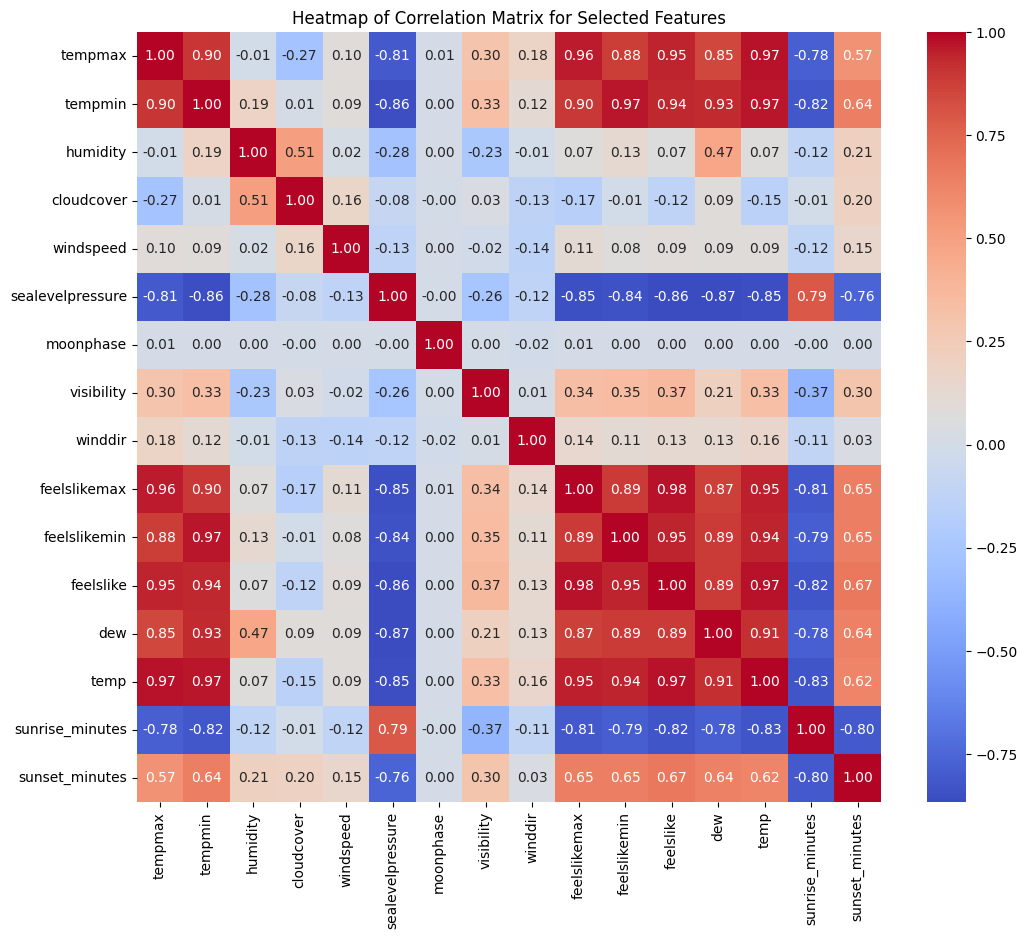

In [641]:
correlation_matrix = df_features.corr()

# In ra ma trận tương quan
print(correlation_matrix)

# Vẽ biểu đồ nhiệt độ tương quan
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Heatmap of Correlation Matrix for Selected Features')
plt.show()

In [642]:
#Thêm condition vào features 
condition_features = [col for col in weather.columns if 'cond_' in col]
features.extend(condition_features)

In [643]:
features

['tempmax',
 'tempmin',
 'humidity',
 'cloudcover',
 'windspeed',
 'sealevelpressure',
 'moonphase',
 'visibility',
 'winddir',
 'feelslikemax',
 'feelslikemin',
 'feelslike',
 'dew',
 'temp',
 'sunrise_minutes',
 'sunset_minutes',
 'cond_Clear',
 'cond_Overcast',
 'cond_Partially cloudy',
 'cond_Rain',
 'cond_Rain, Overcast',
 'cond_Rain, Partially cloudy']

In [644]:
weather.head(5)

,name,datetime,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,...,stations,sunrise_minutes,sunset_minutes,tempmax_next,cond_Clear,cond_Overcast,cond_Partially cloudy,cond_Rain,"cond_Rain, Overcast","cond_Rain, Partially cloudy"
0,Hà Nội,1990-01-01,15.9,13.4,14.6,15.9,13.4,14.6,14.0,96.3,...,48820099999,393,1046,17.4,False,True,False,False,False,False
1,Hà Nội,1990-01-02,17.4,14.6,16.1,17.4,14.6,16.1,13.7,85.9,...,48820099999,394,1046,18.2,False,True,False,False,False,False
2,Hà Nội,1990-01-03,18.2,16.1,16.8,18.2,16.1,16.8,13.8,82.5,...,48820099999,394,1047,19.6,False,True,False,False,False,False
3,Hà Nội,1990-01-04,19.6,15.2,16.4,19.6,15.2,16.4,14.3,88.2,...,48820099999,394,1048,18.1,False,True,False,False,False,False
4,Hà Nội,1990-01-05,18.1,15.4,16.9,18.1,15.4,16.9,15.8,93.8,...,48820099999,394,1048,17.7,False,True,False,False,False,False


In [645]:
def entropy(s):
    values, counts = np.unique(s, return_counts=True)
    probabilities = counts / counts.sum()
    entropy = -np.sum(probabilities * np.log2(probabilities))
    return entropy

In [646]:
tempmax_entropy = entropy(weather['tempmax'])
print("Entropy of tempmax:", tempmax_entropy)

Entropy of tempmax: 7.015482289848042


In [647]:
X = weather[features]
y = weather['tempmax_next']

In [648]:
print("Số lượng giá trị khuyết trong X:")
print(X.isnull().sum())
print("\nSố lượng giá trị khuyết trong y:")
print(y.isnull().sum())

Số lượng giá trị khuyết trong X:
tempmax                        57
tempmin                        57
humidity                       57
cloudcover                     57
windspeed                       0
sealevelpressure               99
moonphase                       0
visibility                     57
winddir                        78
feelslikemax                   57
feelslikemin                   57
feelslike                      57
dew                            57
temp                           57
sunrise_minutes                 0
sunset_minutes                  0
cond_Clear                      0
cond_Overcast                   0
cond_Partially cloudy           0
cond_Rain                       0
cond_Rain, Overcast             0
cond_Rain, Partially cloudy     0
dtype: int64

Số lượng giá trị khuyết trong y:
57


In [649]:
weather_clean = weather.fillna(method='ffill')
X = weather_clean[features]
y = weather_clean['tempmax_next']

C:\Users\Asus\AppData\Local\Temp\ipykernel_23640\927489208.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  weather_clean = weather.fillna(method='ffill')


In [650]:
print("Số lượng giá trị khuyết trong X:")
print(X.isnull().sum())
print("\nSố lượng giá trị khuyết trong y:")
print(y.isnull().sum())

Số lượng giá trị khuyết trong X:
tempmax                        0
tempmin                        0
humidity                       0
cloudcover                     0
windspeed                      0
sealevelpressure               0
moonphase                      0
visibility                     0
winddir                        0
feelslikemax                   0
feelslikemin                   0
feelslike                      0
dew                            0
temp                           0
sunrise_minutes                0
sunset_minutes                 0
cond_Clear                     0
cond_Overcast                  0
cond_Partially cloudy          0
cond_Rain                      0
cond_Rain, Overcast            0
cond_Rain, Partially cloudy    0
dtype: int64

Số lượng giá trị khuyết trong y:
0


In [651]:
# Kiểm tra kiểu dữ liệu của các cột trong `X`
print("\nKiểu dữ liệu của các cột trong X:")
print(X.dtypes)



Kiểu dữ liệu của các cột trong X:
tempmax                        float64
tempmin                        float64
humidity                       float64
cloudcover                     float64
windspeed                      float64
sealevelpressure               float64
moonphase                      float64
visibility                     float64
winddir                        float64
feelslikemax                   float64
feelslikemin                   float64
feelslike                      float64
dew                            float64
temp                           float64
sunrise_minutes                  int64
sunset_minutes                   int64
cond_Clear                        bool
cond_Overcast                     bool
cond_Partially cloudy             bool
cond_Rain                         bool
cond_Rain, Overcast               bool
cond_Rain, Partially cloudy       bool
dtype: object


In [652]:
# Thống kê mô tả cho `X`
print("\nThống kê mô tả cho X:")
print(X.describe())

# Thống kê mô tả cho `y`
print("\nThống kê mô tả cho y:")
print(y.describe())


Thống kê mô tả cho X:
            tempmax       tempmin      humidity    cloudcover    windspeed  \
count  12538.000000  12538.000000  12538.000000  12538.000000  12538.00000   
mean      27.685779     21.365489     80.881377     70.208398     17.29200   
std        5.874247      4.993798     10.396343     25.304971      6.34278   
min        8.000000      3.800000     31.100000      0.000000      0.00000   
25%       23.600000     18.000000     75.000000     56.400000     13.00000   
50%       29.000000     22.900000     82.100000     77.400000     16.60000   
75%       32.200000     25.100000     88.400000     90.100000     21.40000   
max       43.100000     34.600000    100.000000    100.000000     79.20000   

       sealevelpressure     moonphase    visibility       winddir  \
count      12538.000000  12538.000000  12538.000000  12538.000000   
mean        1010.936194      0.483808      8.854307    129.154155   
std            7.031445      0.288608      3.402096     97.098198  

In [653]:
from sklearn.model_selection import train_test_split

# Đầu tiên, chia dữ liệu thành tập huấn luyện và tập kiểm thử
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Tiếp theo, chia tập huấn luyện thành tập huấn luyện mới và tập validation
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2



In [654]:
import numpy as np

class DecisionTreeRegressor:
    def __init__(self, max_depth=None, min_samples_split=2):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.left = None
        self.right = None
        self.threshold = None
        self.feature_index = None
        self.value = None

    def fit(self, X, y, depth=0):
        num_samples, num_features = X.shape
        if num_samples >= self.min_samples_split and (self.max_depth is None or depth < self.max_depth):
            best_split = self._get_best_split(X, y, num_samples, num_features)
            if best_split:
                self.feature_index, self.threshold = best_split
                indices_left = X[:, self.feature_index] < self.threshold
                X_left, y_left = X[indices_left], y[indices_left]
                X_right, y_right = X[~indices_left], y[~indices_left]
                self.left = DecisionTreeRegressor(self.max_depth, self.min_samples_split)
                self.right = DecisionTreeRegressor(self.max_depth, self.min_samples_split)
                self.left.fit(X_left, y_left, depth + 1)
                self.right.fit(X_right, y_right, depth + 1)
        self.value = np.mean(y)

    def _get_best_split(self, X, y, num_samples, num_features):
        best_mse = float("inf")
        best_index = None
        best_threshold = None
        
        for feature_index in range(num_features):
            feature_values = X[:, feature_index]
            sorted_indices = np.argsort(feature_values)
            feature_values, labels = feature_values[sorted_indices], y[sorted_indices]
            
            for i in range(1, num_samples):
                if feature_values[i] == feature_values[i - 1]:
                    continue
                split_threshold = (feature_values[i] + feature_values[i - 1]) / 2
                left_labels, right_labels = labels[:i], labels[i:]
                mse = self._calculate_mse(left_labels, right_labels)
                
                if mse < best_mse:
                    best_mse = mse
                    best_index = feature_index
                    best_threshold = split_threshold
        
        return (best_index, best_threshold) if best_index is not None else None

    def _calculate_mse(self, left_labels, right_labels):
        left_var = np.var(left_labels) * len(left_labels)
        right_var = np.var(right_labels) * len(right_labels)
        return left_var + right_var

    def predict(self, X):
        if self.left is None or self.right is None:
            return np.array([self.value] * len(X))
        
        indices = X[:, self.feature_index] < self.threshold
        left_preds = self.left.predict(X[indices])
        right_preds = self.right.predict(X[~indices])
        
        return np.concatenate([left_preds, right_preds])



In [655]:
class RandomForestRegressor:
    def __init__(self, n_estimators=100, max_depth=None, min_samples_split=2, random_state=None):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.random_state = random_state
        self.trees = []
        if random_state is not None:
            np.random.seed(random_state)

    def fit(self, X, y):
        self.trees = []
        for _ in range(self.n_estimators):
            bootstrap_indices = np.random.choice(len(X), size=len(X), replace=True)
            X_sample, y_sample = X[bootstrap_indices], y[bootstrap_indices]
            tree = DecisionTreeRegressor(self.max_depth, self.min_samples_split)
            tree.fit(X_sample, y_sample)
            self.trees.append(tree)

    def predict(self, X):
        tree_predictions = np.array([tree.predict(X) for tree in self.trees])
        return np.mean(tree_predictions, axis=0)

In [656]:
from sklearn.ensemble import RandomForestRegressor

# Khởi tạo mô hình Random Forest
model = RandomForestRegressor(n_estimators=100, random_state=42)  # Sử dụng 100 cây

# Huấn luyện mô hình trên tập huấn luyện
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [657]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Khởi tạo mô hình Random Forest
model = RandomForestRegressor(n_estimators=100, random_state=42)

model.fit(X_train, y_train)

# Dự đoán trên tập validation
y_val_pred = model.predict(X_val)

# Đánh giá mô hình trên tập validation
mse_val = mean_squared_error(y_val, y_val_pred)
r2_val = r2_score(y_val, y_val_pred)

print("Validation MSE:", mse_val)
print("Validation R-squared:", r2_val)


Validation MSE: 4.769188684210529
Validation R-squared: 0.8617088947781176


In [658]:
# Dự đoán nhiệt độ trên tập kiểm thử
y_pred = model.predict(X_test)

# Đánh giá mô hình bằng Mean Squared Error và R-squared trên tập test
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Test MSE:", mse)
print("Test R-squared:", r2)
print("Kích thước tập huấn luyện:", X_train.shape, y_train.shape)
print("Kích thước tập validation:", X_val.shape, y_val.shape)
print("Kích thước tập kiểm thử:", X_test.shape, y_test.shape)



Test MSE: 4.8152609445773535
Test R-squared: 0.8572996132849282
Kích thước tập huấn luyện: (7522, 22) (7522,)
Kích thước tập validation: (2508, 22) (2508,)
Kích thước tập kiểm thử: (2508, 22) (2508,)


In [659]:
weather

,name,datetime,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,...,stations,sunrise_minutes,sunset_minutes,tempmax_next,cond_Clear,cond_Overcast,cond_Partially cloudy,cond_Rain,"cond_Rain, Overcast","cond_Rain, Partially cloudy"
0,Hà Nội,1990-01-01,15.9,13.4,14.6,15.9,13.4,14.6,14.0,96.3,...,48820099999,393,1046,17.4,False,True,False,False,False,False
1,Hà Nội,1990-01-02,17.4,14.6,16.1,17.4,14.6,16.1,13.7,85.9,...,48820099999,394,1046,18.2,False,True,False,False,False,False
2,Hà Nội,1990-01-03,18.2,16.1,16.8,18.2,16.1,16.8,13.8,82.5,...,48820099999,394,1047,19.6,False,True,False,False,False,False
3,Hà Nội,1990-01-04,19.6,15.2,16.4,19.6,15.2,16.4,14.3,88.2,...,48820099999,394,1048,18.1,False,True,False,False,False,False
4,Hà Nội,1990-01-05,18.1,15.4,16.9,18.1,15.4,16.9,15.8,93.8,...,48820099999,394,1048,17.7,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12533,Hà Nội,2024-04-25,34.0,25.0,28.9,45.6,25.0,34.5,25.9,84.7,...,"48820099999,48823099999,48825099999,4883109999...",330,1099,36.0,False,False,False,False,False,True
12534,Hà Nội,2024-04-26,36.0,27.0,30.9,47.9,31.0,39.6,26.9,80.8,...,VVNB,329,1099,40.0,False,False,True,False,False,False
12535,Hà Nội,2024-04-27,40.0,27.0,32.2,44.7,31.2,38.6,24.7,69.9,...,"48820099999,48823099999,48825099999,4883109999...",328,1100,35.0,True,False,False,False,False,False
12536,Hà Nội,2024-04-28,35.0,27.0,30.4,50.8,30.5,39.4,27.0,82.7,...,"48820099999,48823099999,48825099999,4883109999...",328,1100,34.0,False,False,True,False,False,False


In [660]:
data_30_4 = {
    'tempmax': [36],               # Nhiệt độ cao nhất
    'tempmin': [27],               # Nhiệt độ thấp nhất
    'humidity': [79.9],            # Độ ẩm
    'cloudcover': [40.2],          # Mây che phủ
    'windspeed': [22.3],           # Tốc độ gió
    'sealevelpressure': [999.1],   # Áp suất mực nước biển
    'moonphase' : [0.72],
    'visibility': [9] ,
    'winddir' : [82.5],
    'feelslikemax': [50] ,
    'feelslikemin': [31] ,
    'feelslike': [39.9], 
    'dew' : [26.9],
    'temp': [31],
    'sunrise_minutes': [326],
    'sunset_minutes': [1101],
    'cond_Clear': [0],             # Điều kiện trời quang đãng
    'cond_Overcast': [0],          # Điều kiện trời u ám
    'cond_Partially cloudy': [1],  # Điều kiện trời nhiều mây
    'cond_Rain': [0],              # Điều kiện mưa
    'cond_Rain, Overcast': [0],    # Điều kiện mưa và u ám
    'cond_Rain, Partially cloudy': [0],  # Điều kiện mưa và nhiều mây
    
}

new_data = pd.DataFrame(data_30_4)

In [661]:
new_data

,tempmax,tempmin,humidity,cloudcover,windspeed,sealevelpressure,moonphase,visibility,winddir,feelslikemax,...,dew,temp,sunrise_minutes,sunset_minutes,cond_Clear,cond_Overcast,cond_Partially cloudy,cond_Rain,"cond_Rain, Overcast","cond_Rain, Partially cloudy"
0,36,27,79.9,40.2,22.3,999.1,0.72,9,82.5,50,...,26.9,31,326,1101,0,0,1,0,0,0


In [662]:
predicted_tempmax = model.predict(new_data)
print(f"Dự đoán nhiệt độ cao nhất cho ngày 1 tháng 5 tại Hà Nội là: {predicted_tempmax[0]}°C")

Dự đoán nhiệt độ cao nhất cho ngày 1 tháng 5 tại Hà Nội là: 34.398999999999994°C


## TỐI ƯU

In [663]:
from sklearn.model_selection import GridSearchCV

# Định nghĩa lưới tham số
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],  # Số lượng cây quyết định
    'max_features': ['auto', 'sqrt', 'log2'],  # Số lượng đặc trưng để xem xét khi tìm kiếm phân chia tốt nhất
    'max_depth': [None, 10, 20, 30],  # Độ sâu tối đa của cây
    'min_samples_split': [2, 5, 10],  # Số lượng mẫu tối thiểu cần thiết để chia nút
    'min_samples_leaf': [1, 2, 4]  # Số lượng mẫu tối thiểu tại nút lá
}

# Khởi tạo mô hình RandomForestRegressor
rf = RandomForestRegressor(random_state=42)

# Khởi tạo GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')

# Huấn luyện GridSearchCV trên tập dữ liệu huấn luyện
grid_search.fit(X_train, y_train)


Fitting 3 folds for each of 540 candidates, totalling 1620 fits


c:\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
540 fits failed out of a total of 1620.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
357 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Python312\Lib\site-packages\sklearn\base.py", line 1467, in wrapper
    estimator._validate_params()
  File "c:\Python312\Lib\site-packages\sklearn\base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "c:\Python312\Lib\site-packages\sklearn\utils\_param_validation.py", line 95, in validat

GridSearchCV(cv=3, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20, 30],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300, 400, 500]},
             scoring='neg_mean_squared_error', verbose=2)

In [664]:
# Thông tin về tham số tốt nhất và MSE tốt nhất
print("Best parameters:", grid_search.best_params_)
best_model = grid_search.best_estimator_

# Đánh giá mô hình tốt nhất trên tập validation
y_val_pred = best_model.predict(X_val)
mse_val = mean_squared_error(y_val, y_val_pred)
r2_val = r2_score(y_val, y_val_pred)

print("Optimized Validation MSE:", mse_val)
print("Optimized Validation R-squared:", r2_val)

# Sử dụng mô hình tốt nhất để dự đoán trên new data
predicted_tempmax = best_model.predict(new_data)
print(f"Dự đoán nhiệt độ cao nhất cho ngày 1 tháng 5 tại Hà Nội là: {predicted_tempmax[0]}°C")


Best parameters: {'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 500}
Optimized Validation MSE: 4.674086363211646
Optimized Validation R-squared: 0.8644665556615387
Dự đoán nhiệt độ cao nhất cho ngày 1 tháng 5 tại Hà Nội là: 34.0921734624311°C
